# Import packages

In [5]:
import os
# import requests
# import networkx as nx
# import pandas as pd
# import geopandas as gpd
# from pyvis.network import Network
# import openai
from IPython.display import display, HTML, Code
from IPython.display import clear_output

In [6]:
# %load_ext autoreload
# %autoreload 2

import LLM_Geo_Constants as constants
import helper
# import LLM_Geo_kernel.Solution as Solution

from LLM_Geo_kernel import Solution

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# #Case 1: population living near hazardous wastes

# task_name ='Resident_at_risk_counting'

# TASK = r"""1) Find out the total population that lives within a tract that contain hazardous waste facilities. The study area is North Carolina, US.
# 2) Generate a map to show the spatial distribution of population at the tract level and highlight the borders of tracts that have hazardous waste facilitiesm, also show the facility location.
# """
# DATA_LOCATIONS = ["NC hazardous waste facility ESRI shape file location: https://github.com/gladcolor/LLM- Geo/raw/master/overlay_analysis/Hazardous_Waste_Sites.zip.",
#                   "NC tract boundary shapefile location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_shp_37.zip. The tract id column is 'Tract'.",
#                   "NC tract population CSV file location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv. The population is stored in 'TotalPopulation' column. The tract ID column is 'GEOID'."
#                  ]


# Case 2: France_mobility_changes_2020
# task_name ='France_mobility_changes_2020'
# TASK = r'''
# 1) Show the 2020 human mobility monthly change rates of each administrative regions in a France choropleth map. Each month is a sub-map in a map matrix，12 months in total. All monthly maps need to use the same colorbar range. The base of the change rate is January 2020. 
# 2) Draw a line chart to show the monthly change rate trends of all administrative regeions. Each region is a line (the region name is the legend), the x-axis is 2020 months.
# '''

# DATA_LOCATIONS = ["ESRI shapefile for France administrative regions:" + \
#                   "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip. " + \
#                   "The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.",
#                   "REST API url with parameters for daily human mobility data access:" + \
#                   "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020." + \
#                   "The response is in CSV format. There are three columns in the response: " + \
#                   "place,date (format:2020-01-07), and intra_movement. 'place' column is the administractive region code of every country;" + \
#                   "codes for France administrative regions start with 'FRA'. Use the total intra_movement of the month as the montly mobility.",
#                  ]


# # Case 3: COVID-19 death rate prevalence trend
task_name ='COVID_death_rate'
TASK = r'''1) Draw a choropleth map to show the death rate (death/case) of COVID-19 among the countiguous US counties. Use the accumulated COVID-19 data of 2020.12.31 to compute the death rate. Use scheme ='quantiles' when plotting the map.  Set map projection to 'Conus Albers'. Set map size to 15*10 inches.  
2) Draw a scatter plot to show the correlation and trend line of the death rate with the senior resident rate, including the r-square and p-value. Set data point transparency to 50%, regression line as red.  Set figure size to 15*10 inches.  
'''


DATA_LOCATIONS = [
                  r"COVID-19 data case in 2020 (county-level): https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv. This data is for daily accumulated COVID cases and deaths for each county in the US. There are 5 columns: date (format: 2021-02-01), county, state, fips, cases, deaths. ",   
                  r"Contiguous US county boundary (ESRI shapefile): https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip. The county FIPS column is 'GEOID'; map projection is EPSG:4269",
                  r"Census data (ACS2020): https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv. THe needed columns are: 'FIPS', 'Total Population', 'Total Population: 65 to 74 Years', 'Total Population: 75 to 84 Years', 'Total Population: 85 Years and Over'. Drop rows with NaN cells after loading the used columns.",
                 ]

 

# # # Case 4: Hospital_accessibility
# task_name ='Hospital_accessibility'
# TASK = r'''
# For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map of zipcode area polygons (unit: km), also show the hospital.
# '''

# DATA_LOCATIONS = [
# r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, the map projection is WGS1984.",
# r"SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: longitude in 'POINT_X' column, latitude in 'POINT_Y' column.",          
# ]


## Case 5: Census API
# task_name ='Census_API'
# TASK = r''' Show the spatial distribution of the county level median income in the contigous US. Set figure size to (25,15)
# '''

# DATA_LOCATIONS = [
#       "You can use the Census API.",
# ]

# '''Census API key: ae7be70727932dd6aed257692de3f344365d0678'''        

 
save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model=r"gpt-3.5-turbo"
model=r"gpt-4"
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.direct_request_prompt)

Prompt to get solution graph:

Your role: A professional Geo-information scientist and developer good at Python. You have worked on 
Geographic information science more than 20 years, and know every detail and pitfall when processing spatial data and coding. 
Yor program is always concise and robust, considering the various data circumstances. You are also super experienced on generating map.
 
Your task: Write a Python program to address the question or task: 1) Draw a choropleth map to show the death rate (death/case) of COVID-19 among the countiguous US counties. Use the accumulated COVID-19 data of 2020.12.31 to compute the death rate. Use scheme ='quantiles' when plotting the map.  Set map projection to 'Conus Albers'. Set map size to 15*10 inches.  
2) Draw a scatter plot to show the correlation and trend line of the death rate with the senior resident rate, including the r-square and p-value. Set data point transparency to 50%, regression line as red.  Set figure size to 15*10 i

```python
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from matplotlib.colors import ListedColormap
import requests
from io import BytesIO
from zipfile import ZipFile

def direct_solution():
    
    # 1) Draw a choropleth map to show the death rate (death/case) of COVID-19 among the countiguous US counties.
       
    covid_data_url = 'https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv'
    # Reading as str to avoid the FIPS float issue
    covid_df = pd.read_csv(covid_data_url, dtype={'fips': 'str'})
    
    # Select data of 2020.12.31
    covid_df = covid_df[covid_df['date'] == '2020-12-31']

    # Calculate death rate
    covid_df['death_rate'] = covid_df['deaths'] / covid_df['cases']

    # Ensure 'fips' has leading zeros by using zfill
    covid_df['fips'] = covid_df['fips'].str.zfill(5)

    counties_shp_url = 'https://github.com/gladcolor/spatial_data/raw/master/contiguous_count

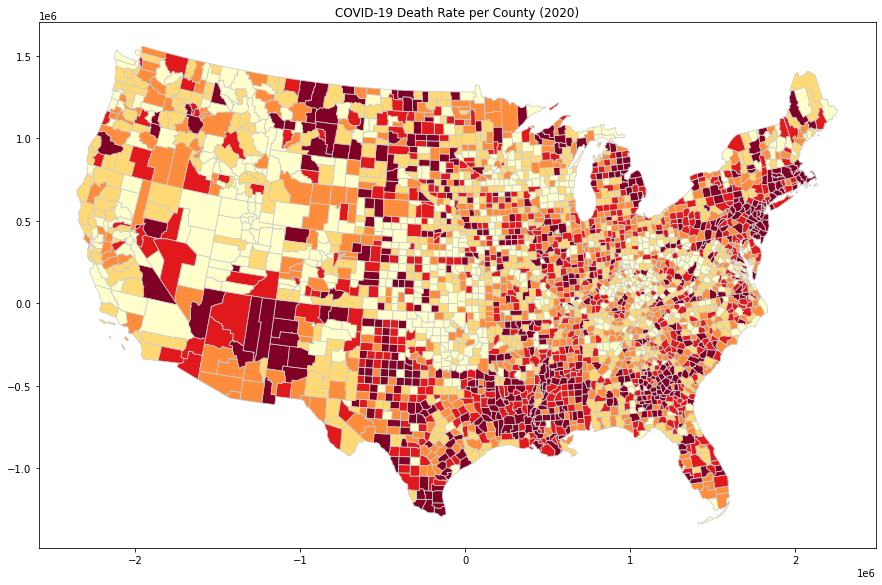

Error_info_str: 
Traceback (most recent call last):
  File "Complete program", line 85, in <module>
    direct_solution()
  File "Complete program", line 77, in direct_solution
    sns.lineplot(final_df['senior_rate'], slope * final_df['senior_rate'] + intercept, color='red')
TypeError: lineplot() takes from 0 to 1 positional arguments but 2 were given

Sending error information to LLM for debugging...
The code is correct for the most part, but there is indeed an error while calling `sns.lineplot()`. `sns.lineplot()` function requires the dataset to be specified (if any), and x and y should be the names of variables in data. After specifying x, y parameters and data, it will automatically compute the regression line.

Here is the corrected version:

```python
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from matplotlib.colors import ListedColormap
import requests
from io import BytesIO
from zipfile import ZipF

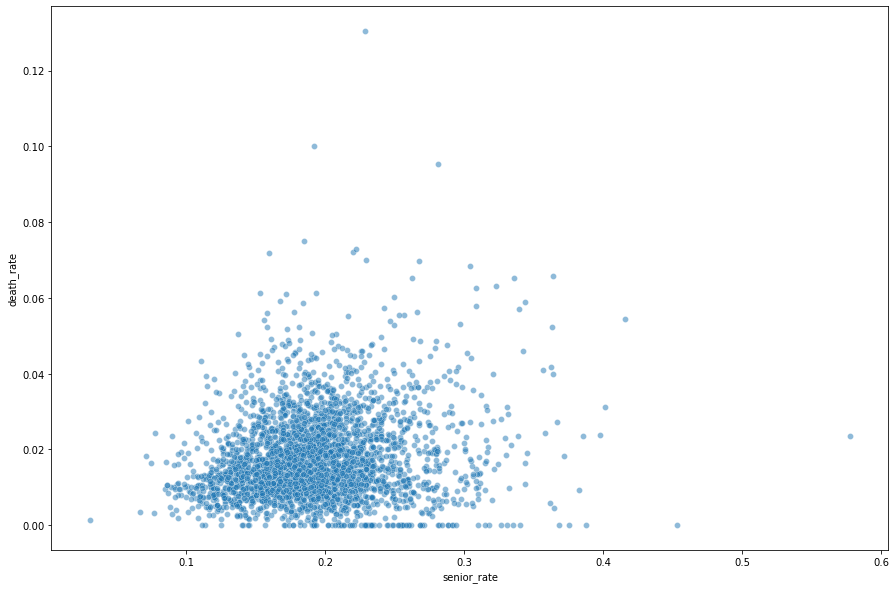

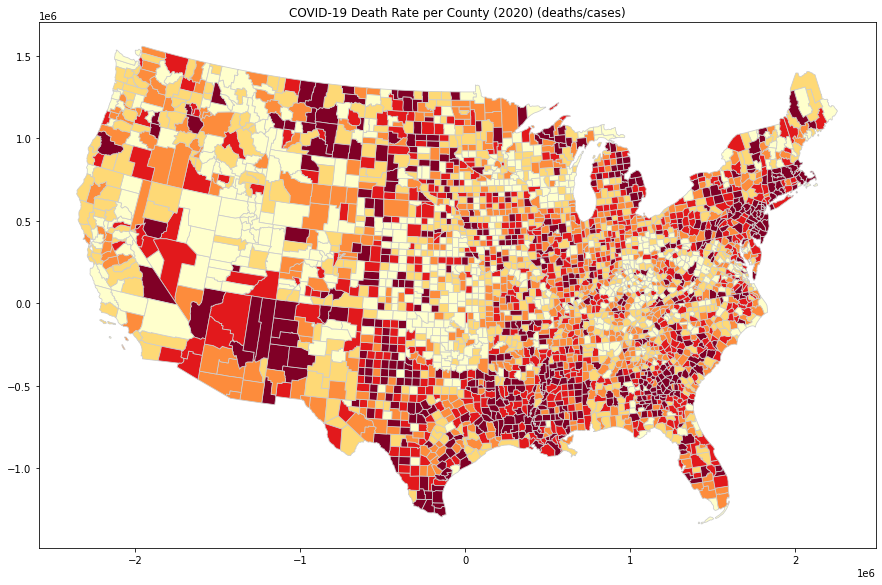

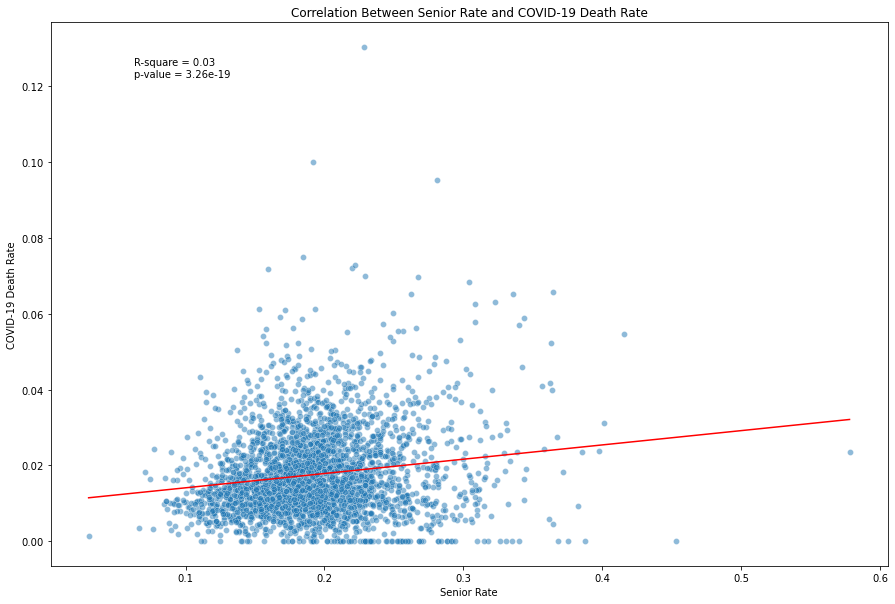



--------------- Done ---------------




In [8]:
direct_request_LLM_response = solution.get_direct_request_LLM_response(review=True)

# clear_output(wait=True)
# display(Code(solution.direct_request_code, language='python'))

code = solution.execute_complete_program(code=solution.direct_request_code, try_cnt=10)
# solution.direct_request_code = code
# display(Code(code, language='python'))
